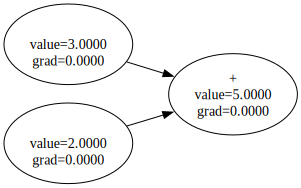

In [ ]:
#I'm going to create a simple graph which will have nodes and edges, be able to do derivatives and thus backpropagation.
#which will be visualized using graphviz.

from graphviz import Digraph

class Node:
    def __init__(self, value, children=(), op=''):
        self.value = value
        self.grad = 0.0
        self._backward = lambda: None
        self.children = children
        self.op = op

    def __add__(self, other):
        out = Node(self.value + other.value, (self, other), '+')
        return out
    
    def __sub__(self, other):
        out = Node(self.value - other.value, (self, other), '-')
        return out

    def __mul__(self, other):
        out = Node(self.value * other.value, (self, other), '*')    
        return out
    
    def __repr__(self):
        return f"Node(value={self.value}, grad={self.grad}, op='{self.op}')"


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges



def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(uid, label=f"{n.op}\nvalue={n.value:.4f}\ngrad={n.grad:.4f}")

    for a, b in edges:
        dot.edge(str(id(a)), str(id(b)))

    return dot

n1 = Node(2.0)
n2 = Node(3.0)  

n3 = n1.__add__(n2)
dot = draw_dot(n3)
dot

#from here i will implement backpropagation on my own 


